## Import các thư viện cần thiết

In [14]:
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(561)
sns.set(rc={"figure.figsize":(10, 8)})

## Đọc dữ liệu

In [15]:
dataset = pd.read_csv("./clean-data/clean_data.csv")
dataset.head()

,TotalEmployees,TotalEmployeesIndia,Rating,CompanyType,Name,CompanyReviewsLive,CompanySalaries,InterviewExperiencesLive,Age,HQCountry,Headquarters,CompanyJobsLive,LocationCount,Industry
0,100001.0,100001.0,1,Public,Tata Consultancy Services,41589,394003,2783,54,India,Mumbai,55,240,"BPO / Call Centre,IT Services & Consulting"
1,100001.0,100001.0,2,Public,Accenture,27770,268685,2177,33,Ireland,Dublin,7294,132,"IT Services & Consulting,Software Product"
2,100001.0,100001.0,1,Private,Cognizant,25176,272214,1748,28,United States (USA),Teaneck,316,88,IT Services & Consulting
3,100001.0,100001.0,2,Public,ICICI Bank,32063,100049,940,28,India,Mumbai,150,995,"Financial Services,Banking"
4,100001.0,100001.0,1,Public,Wipro,23674,200635,1819,77,India,Bangalore/Bengaluru,520,254,IT Services & Consulting


In [16]:
print("Kích thước dataset : ", dataset.shape)

Kích thước dataset :  (9988, 14)


## Phân bố các giá trị Rating

<AxesSubplot:ylabel='Rating'>

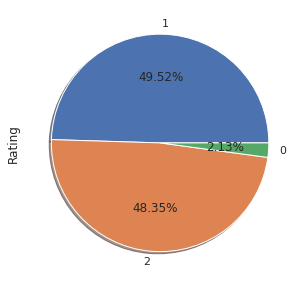

In [17]:
dataset["Rating"].value_counts().plot.pie(figsize=(5, 5), shadow=True, autopct="%1.2f%%")

Ta thấy lớp Rating 0 chiếm tỉ lệ rất nhỏ sẽ làm mô hình phân loại kém hiêu quả (kể cả khi áp dụng Resample) nên ta tiến hành loại bỏ và chỉ giữ lại hai lớp Rating 1 và 2 

In [18]:
dataset.drop(dataset[dataset["Rating"] == 0].index, inplace=True)

<AxesSubplot:ylabel='Rating'>

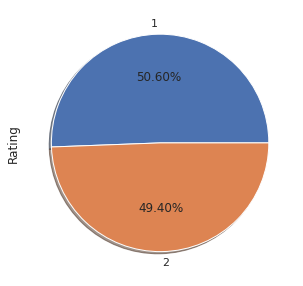

In [19]:
dataset["Rating"].value_counts().plot.pie(figsize=(5, 5), shadow=True, autopct="%1.2f%%")

In [20]:
print("Kích thước dataset mới : ", dataset.shape)

Kích thước dataset mới :  (9775, 14)


## Chia dữ liệu Train / Test

Chia theo tỉ lệ 20/80, stratify theo Potability để tỉ lệ nước uống được/không uống được bằng nhau ở 2 tập train và test

In [21]:
X_columns = ["TotalEmployees", "TotalEmployeesIndia", "CompanyReviewsLive", "CompanySalaries", 
             "InterviewExperiencesLive", "Age", "CompanyJobsLive", "LocationCount"]
Y_columns = "Rating"

X_train, X_test, Y_train, Y_test = train_test_split(dataset[X_columns].fillna(0),
                                                    dataset[Y_columns],
                                                    test_size=0.2, 
                                                    stratify=dataset[Y_columns],
                                                    random_state=42)

X_train.shape, X_test.shape

((7820, 8), (1955, 8))

Tỉ lệ các lớp Rating 2 tập train và test

<AxesSubplot:ylabel='Rating'>

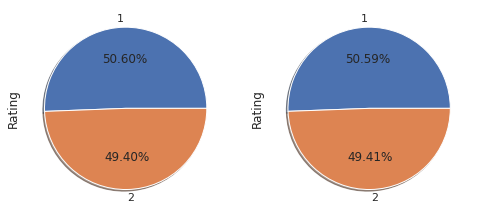

In [22]:
plt.subplot(1, 2, 1)
Y_train.value_counts().plot.pie(figsize=(8, 8), shadow=True, autopct='%1.2f%%')

plt.subplot(1, 2, 2)
Y_test.value_counts().plot.pie(figsize=(8, 8), shadow=True, autopct='%1.2f%%')

## Phân tích tập Train

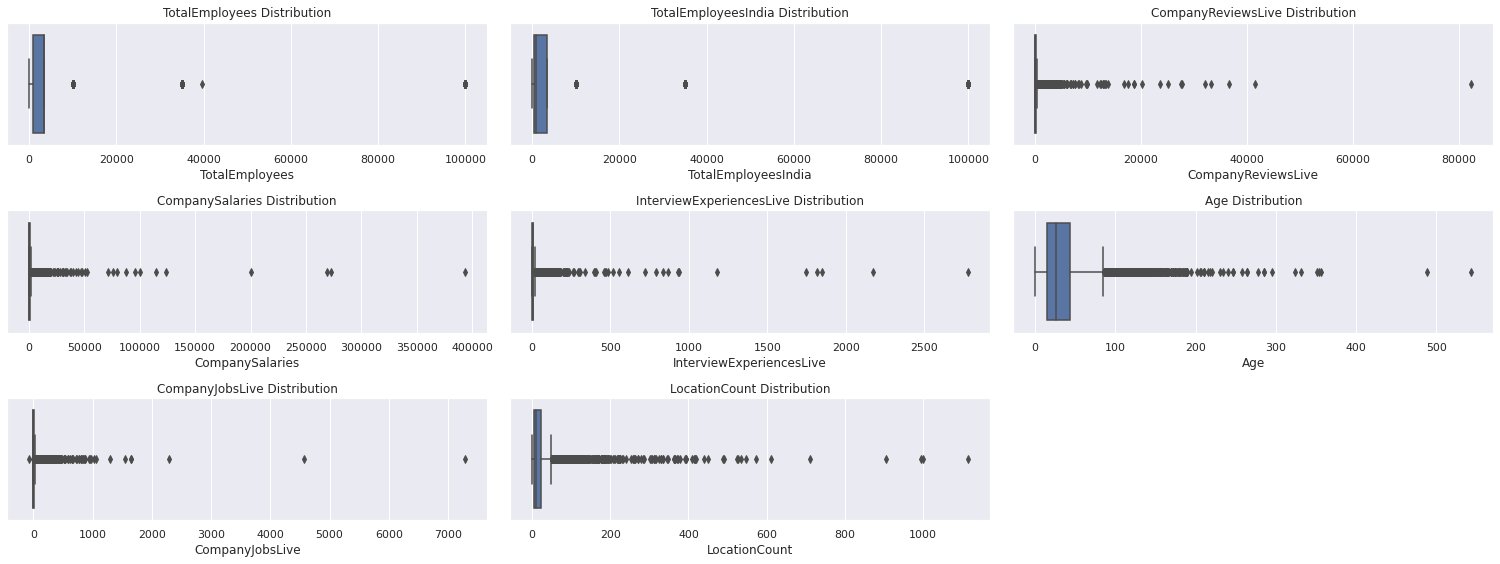

In [23]:
plt.figure(figsize=(21, 8))

for i in range(len(X_columns)):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=X_train, x=X_columns[i])
    plt.title(X_columns[i] + " Distribution")

plt.tight_layout()

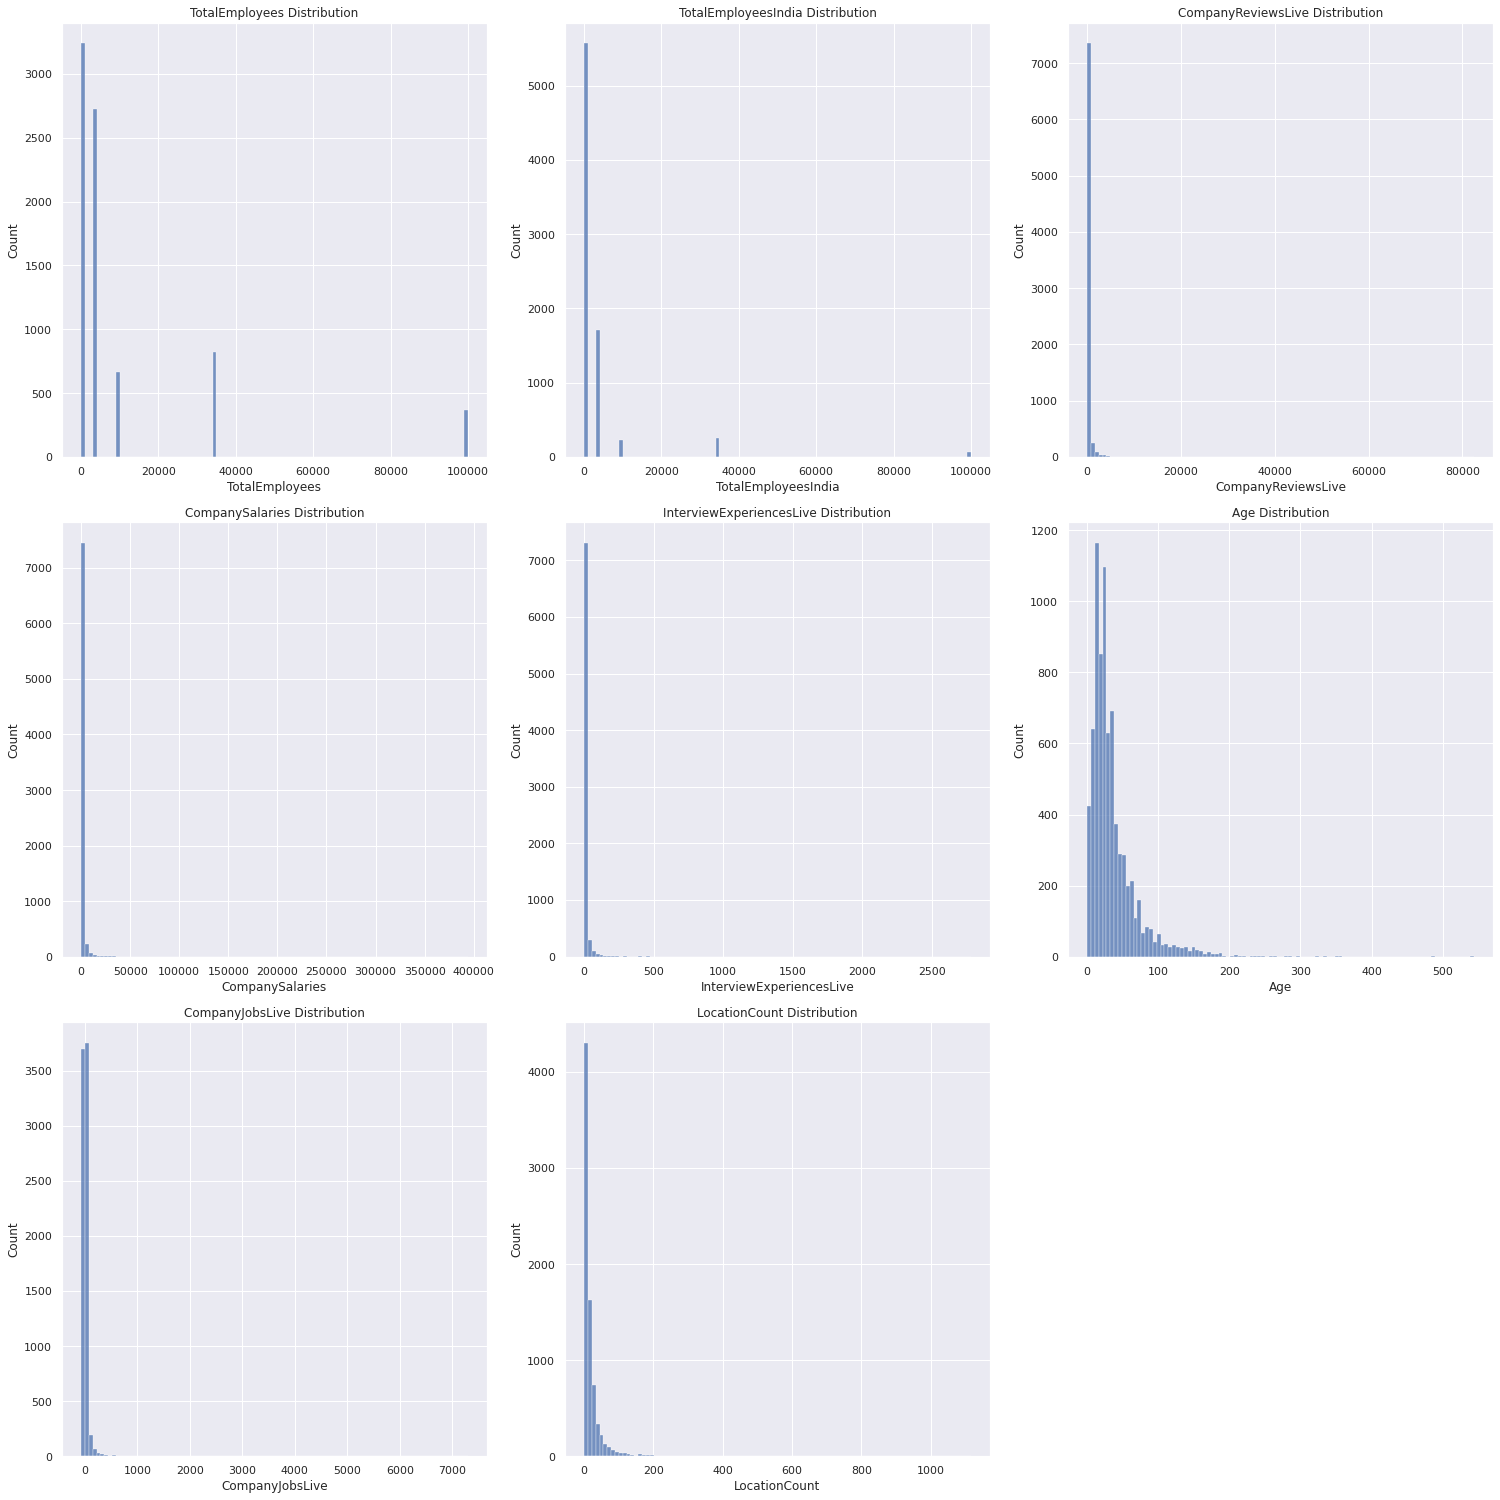

In [24]:
plt.figure(figsize=(21, 21))

for i in range(len(X_columns)):
    plt.subplot(3, 3, i+1)
    sns.histplot(X_train[X_columns[i]], bins=100)
    plt.title(X_columns[i] + " Distribution")

plt.tight_layout()

## Xử lý ngoại lệ trên tập Train

In [26]:
def outliers_iqr(dataset, list_columns):
    data = dataset.copy()
    for col in list_columns:
        quantile_1, quantitle_3 = np.percentile(data[col], [25, 75])
        iqr = quantitle_3 - quantile_1
        lower_bound = quantile_1 - (iqr * 1.5)
        upper_bound = quantitle_3 + (iqr * 1.5)
        data[col] = data[col].clip(lower_bound, upper_bound)
    return data


# Tập X_train gốc có xử lý ngoại lệ
X_train_outlier = outliers_iqr(X_train, X_columns)

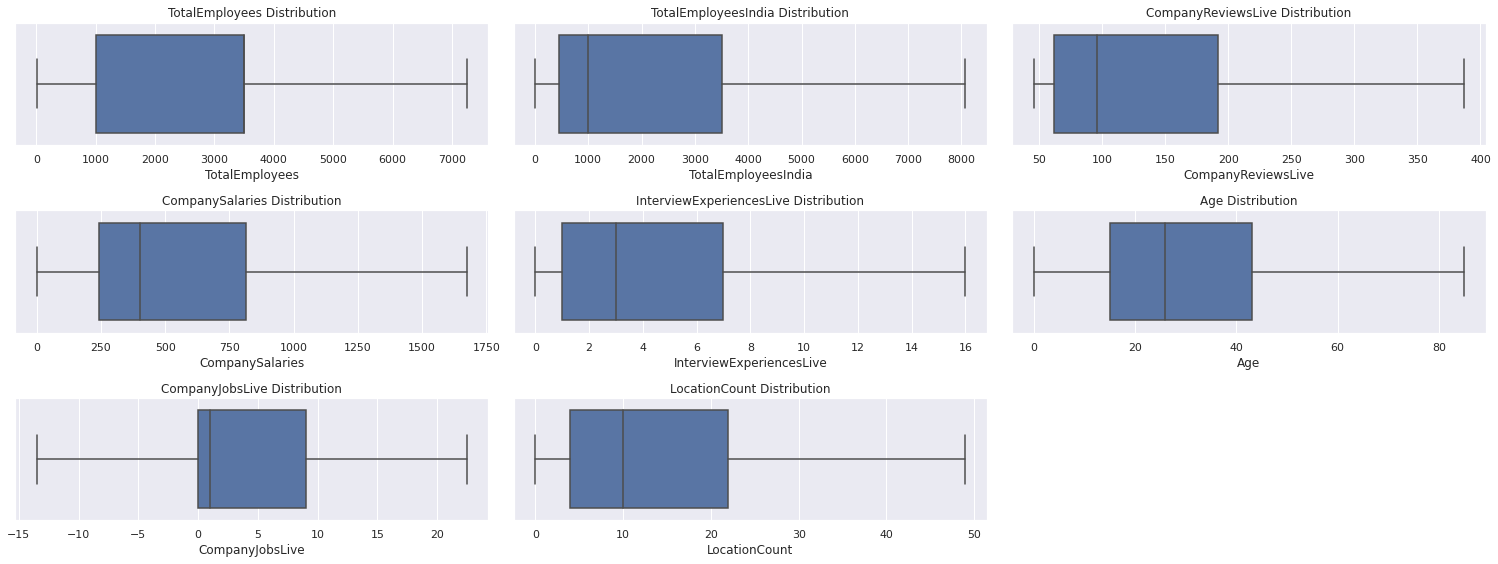

In [27]:
plt.figure(figsize=(21, 8))

for i in range(len(X_columns)):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=X_train_outlier, x=X_columns[i])
    plt.title(X_columns[i] + " Distribution")

plt.tight_layout()

## Chuẩn hóa Z-score

Áp dụng chuẩn hóa bằng cách fit cho tập Train và dùng bộ tham số đó để transform cho cả tập Train và Test 

In [37]:
X_test_outlier = X_test.copy()

# Chuẩn hóa tập Train gốc
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# Sử dụng lại chính scaler của tập Train để chuẩn hóa cho tập Test
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Chuẩn hóa tập Train gốc có xử lý ngoại lệ
scaler = StandardScaler()
scaler.fit(X_train_outlier)
X_train_outlier = pd.DataFrame(scaler.transform(X_train_outlier), columns=X_train_outlier.columns)
X_test_outlier = pd.DataFrame(scaler.transform(X_test_outlier), columns=X_test_outlier.columns)

## Format độ chính xác về %

In [38]:
def acc(accuracy):
    return f"{round(accuracy*100, 2)} (%)"

## Hyperparameter Tuning

##### Sử dụng GridSearchCV với tham số cv = 5 để áp dụng 5-Fold Cross-Validation. Tương ứng với việc kiểm thử chéo 5 lần với tỉ lệ tập Train:Validation là 4:1

## Random Forest

Các siêu tham số ta đang xét : 
- n_estimators : số lượng cây quyết định được tạo ra trong thụât toán Rừng ngẫu nhiên
- min_samples_leaf : số mẫu dữ liệu tối thiểu ở mỗi lá để xây dựng "bộ câu hỏi"

In [39]:
def hyperparameter_tuning_rfc(XTrain, YTrain):
    random_forest = RandomForestClassifier(random_state=42)
    params = {
        "n_estimators": [100, 200, 300, 400],
        "min_samples_leaf": [1, 2, 10]
    }
    search = GridSearchCV(estimator=random_forest, param_grid=params, cv=5, n_jobs=-1)
    search.fit(XTrain, YTrain)
    # Kết quả Tuning tốt nhất
    print(f"Best : {acc(search.best_score_)} using {search.best_params_}")
    return search.best_params_


print(">> X_train gốc : ")
best_params_rf_1 = hyperparameter_tuning_rfc(X_train, Y_train)
print(">> X_train có xử lý ngoại lệ : ")
best_params_rf_2 = hyperparameter_tuning_rfc(X_train_outlier, Y_train)

>> X_train gốc : 
Best : 65.68 (%) using {'min_samples_leaf': 1, 'n_estimators': 400}
>> X_train có xử lý ngoại lệ : 
Best : 65.13 (%) using {'min_samples_leaf': 2, 'n_estimators': 400}


### Xây dựng model từ bộ siêu tham số tìm được

>> X_train gốc : 
66.04 (%)
>> X_train có xử lý ngoại lệ : 
65.73 (%)


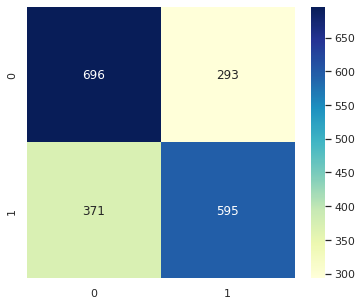

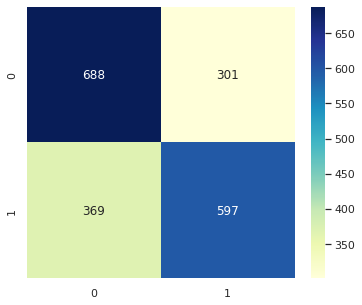

In [40]:
def RF_Model(XTrain, YTrain, XTest, YTest,best_params):
    random_forest = RandomForestClassifier(n_estimators=best_params["n_estimators"],
                                           min_samples_leaf=best_params["min_samples_leaf"],
                                           random_state=42)
    random_forest.fit(XTrain,YTrain)
    Y_pred = random_forest.predict(XTest)

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(YTest, Y_pred), cmap="YlGnBu", annot=True, fmt='g')
    print(acc(accuracy_score(YTest,Y_pred)))


print(">> X_train gốc : ")
RF_Model(X_train, Y_train, X_test, Y_test, best_params_rf_1)
print(">> X_train có xử lý ngoại lệ : ")
RF_Model(X_train_outlier, Y_train, X_test_outlier, Y_test, best_params_rf_2)

## SVM

Các siêu tham số ta đang xét : 
- C :  tham số chính quy. C tỉ lệ nghịch với độ lớn của hàm trừng phạt (penalty) L2
- kernel : loại kernel được sử dụng để tìm siêu phẳng phân chia các lớp
- gamma : hệ số kernel cho các loại kernel : rbf, poly, sigmoid

In [41]:
def hyperparameter_tuning_svm(XTrain, YTrain):
    svm_model = SVC()
    params = {
        'C': [0.1,1,10],
        'gamma': ['scale','auto'],
        'kernel': ['rbf','linear']
    }
    search = GridSearchCV(estimator=svm_model, param_grid=params, cv=5, n_jobs=-1)
    search.fit(XTrain, YTrain)
    # Kết quả Tuning tốt nhất
    print(f"Best : {acc(search.best_score_)} using {search.best_params_}")
    return search.best_params_


print(">> X_train gốc : ")
best_params_svm_1 = hyperparameter_tuning_svm(X_train, Y_train)
print(">> X_train có xử lý ngoại lệ : ")
best_params_svm_2 = hyperparameter_tuning_svm(X_train_outlier, Y_train)

>> X_train gốc : 
Best : 59.48 (%) using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
>> X_train có xử lý ngoại lệ : 
Best : 60.86 (%) using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


### Xây dựng model từ bộ siêu tham số tìm được

>> X_train gốc : 
61.74 (%)
>> X_train có xử lý ngoại lệ : 
61.74 (%)


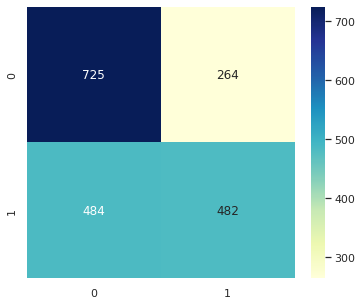

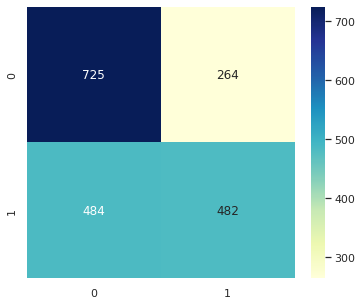

In [42]:
def SVM_Model(XTrain, YTrain, XTest, YTest, best_params):
    svm_model = SVC(C=best_params["C"],
                    gamma=best_params["gamma"],
                    kernel=best_params["kernel"])
    svm_model.fit(XTrain, YTrain)
    Y_pred = svm_model.predict(XTest)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(YTest, Y_pred), cmap="YlGnBu", annot=True, fmt='g')
    print(acc(accuracy_score(YTest, Y_pred)))


print(">> X_train gốc : ")
SVM_Model(X_train, Y_train, X_test, Y_test, best_params_svm_1)
print(">> X_train có xử lý ngoại lệ : ")
SVM_Model(X_train, Y_train, X_test, Y_test, best_params_svm_2)

## Huấn luyện lại Model trên toàn bộ dữ liệu ở 4 trường hợp

In [44]:
# def cross_val_model(X, Y, best_params):
#     model = RandomForestClassifier(
#         n_estimators=best_params["n_estimators"],
#         min_samples_leaf=best_params["min_samples_leaf"],
#         random_state=42)
#     scores = cross_val_score(model, X, Y, cv=5)
#     print(acc(np.mean(scores)))


# print(">> X_train gốc : ")
# cross_val_model(pd.concat([X_train, X_test]), pd.concat([Y_train, Y_test]), best_params_rf_1)
# print(">> X_train gốc có xử lý ngoại lệ : ")
# cross_val_model(pd.concat([X_train_outlier, X_test_outlier]), pd.concat([Y_train, Y_test]), best_params_rf_2)


>> X_train gốc : 
66.37 (%)
>> X_train gốc có xử lý ngoại lệ : 
65.71 (%)
